In [1]:
!pip3 install seqeval

     |████████████████████████████████| 51kB 5.3MB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-cp37-none-any.whl size=16184 sha256=97b58c932798f9296a3fd3a8f5990a4b35153779080ba74df854d3735ba26a3b
  Stored in directory: /root/.cache/pip/wheels/52/df/1b/45d75646c37428f7e626214704a0e35bd3cfc32eda37e59e5f
Successfully built seqeval


In [2]:
pip install tensorflow

In [3]:
 import pandas as pd
annotations = pd.read_csv("chap4_mahabharath_annotations.csv", index_col=['id'])

In [4]:
annotations

,sentence#,token,tag
id,,,
0,0,Om,CONCEPT
1,0,!,O
2,1,Having,O
3,1,bowed,O
4,1,down,O
...,...,...,...
830510,34331,The,O
830511,34331,end,O
830512,34331,of,O


In [5]:
words = list(annotations['token'].values)
words.append('PADword')
n_words = len(set(words))
n_words, len(words)

(19573, 830516)

In [6]:
tags = list(set(annotations["tag"].values))
n_tags = len(tags)
print(n_tags)
tags

12


['SPECIAL_OBJECT',
 'TITLE',
 'WEAPON',
 'PLANT',
 'CONCEPT',
 'O',
 'WATER',
 'GROUP',
 'BOOK',
 'PLACE',
 'PERSON',
 'ANIMAL']

In [7]:
class SentenceGetter(object):
    
    def __init__(self, data):
        self.n_sent = 0
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, t) for w, t in zip(s["token"].values.tolist(),s["tag"].values.tolist())]
        self.grouped = self.data.groupby("sentence#").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped[self.n_sent]
            self.n_sent += 1
            return s
        except:
            return None

In [8]:
getter = SentenceGetter(annotations)
sent = getter.get_next()
print(sent)

[('Om', 'CONCEPT'), ('!', 'O')]


In [9]:
sentences = getter.sentences
print(len(sentences))

34332


In [10]:
sentences[0][0][1]

'CONCEPT'

In [11]:
largest_sen = max(len(sen) for sen in sentences)
print('biggest sentence has {} words'.format(largest_sen))

biggest sentence has 428 words


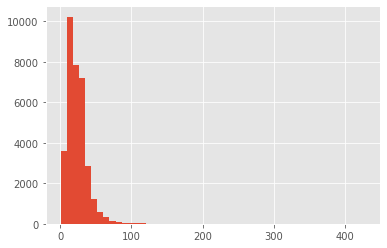

In [12]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline
plt.hist([len(s) for s in sentences], bins = 50)
plt.show()

In [13]:
max_len = 50
X = [[str(w[0]) for w in s] for s in sentences]


In [14]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [15]:
living_entity_tags = ['ANIMAL','PERSON','GROUP','TITLE']
non_living_entity_tags = ['BOOK','PLACE','WEAPON','SPECIAL_OBJECT','PLANT','CONCEPT','WATER']

#for extraction of entities
tags2index = {}
for tag in tags:
    if tag not in living_entity_tags and tag not in non_living_entity_tags:
        tags2index[tag] = 0
    elif tag in living_entity_tags:
        tags2index[tag] = 1
    else:
        tags2index[tag] = 2

In [16]:
Y = [[tags2index[w[1]] for w in s] for s in sentences]
Y = pad_sequences(maxlen=max_len, sequences=Y, value=0, padding='post', truncating='post')

In [17]:
Y[0]

array([2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0], dtype=int32)

In [18]:
X_sent=[]
for i in range(len(X)):
  X_sent.append(["BOS"]+X[i]+["EOS"])

In [19]:
X_join=[]
for i in range(len(X_sent)):
  X_join.append(" ".join(X_sent[i]))

In [20]:
len(X_join)

34332

In [23]:
Y

array([[2, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 1, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)

In [ ]:
y.shape

TensorShape([36078, 50])

In [ ]:
np.array(X_join).shape

(34332,)

In [21]:
!pip install transformers
!pip install sentencepiece

     |████████████████████████████████| 2.5MB 7.8MB/s 
     |████████████████████████████████| 3.3MB 48.7MB/s 
     |████████████████████████████████| 901kB 43.5MB/s 
     |████████████████████████████████| 1.2MB 8.2MB/s 


In [22]:
import tensorflow as tf

In [23]:
X_join[0]

'BOS Om ! EOS'

In [24]:
np.array(X_join).shape

(34332,)

In [25]:
import keras
from sklearn.model_selection import train_test_split
import tensorflow_hub as hub
import tensorflow as tf
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import add, LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional, Lambda,concatenate
import seqeval
from seqeval.metrics import precision_score, recall_score, f1_score, classification_report

In [26]:
X_tr, X_te, y_tr, y_te = train_test_split(X_join, Y, test_size=0.1, random_state=2021)
batch_size = 32

In [27]:
from transformers import AlbertTokenizer
albert = 'albert-base-v2'

tokenizer = AlbertTokenizer.from_pretrained(albert, do_lower_case=True, add_special_tokens=True,
                                                max_length=max_len, pad_to_max_length=True)

In [28]:
 def tokenize(sentences, tokenizer):
    input_ids = []
    input_masks = []
    for sent in sentences:
      inputs = tokenizer.encode_plus(sent, 
                                     add_special_tokens=True,
                                     max_length=50,
                                     pad_to_max_length = True, 
                                     return_attention_mask=True,
                                     return_token_type_ids=True,
                                     truncation=True)
      input_ids.append(inputs['input_ids'])
      input_masks.append(inputs['attention_mask'])
      #input_segments.append(inputs['token_type_ids'])        
        
    return np.asarray(input_ids, dtype='int32'), np.asarray(input_masks, dtype='int32')




In [29]:
len(X_tr), len(X_te), batch_size,len(X_tr)/batch_size, len(X_te)/batch_size 

(30898, 3434, 32, 965.5625, 107.3125)

In [30]:
X_tr, X_val = X_tr[:865*batch_size], X_tr[-100*batch_size:]
y_tr, y_val = y_tr[:865*batch_size], y_tr[-100*batch_size:]
#y_tr = y_tr.reshape(y_tr.shape[0], 1)
#y_val = y_val.reshape(y_val.shape[0], 1)

In [31]:
X_tr_in,X_tr_mask = tokenize(X_tr,tokenizer)
X_val_in,X_val_mask = tokenize(X_val,tokenizer)
X_te_in,X_te_mask = tokenize(X_te,tokenizer)
#y_tr_in,y_tr_mask,_ = np.array(tokenize(y_tr,tokenizer))
#y_val_in,y_val_mask,_ = np.array(tokenize(y_val,tokenizer))

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2111: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [32]:
X_tr_in

array([[    2, 11054,    13, ...,     0,     0,     0],
       [    2, 11054,    17, ...,     0,     0,     0],
       [    2, 11054,    17, ...,     0,     0,     0],
       ...,
       [    2, 11054,    31, ...,     0,     0,     0],
       [    2, 11054,    17, ...,     0,     0,     0],
       [    2, 11054,    13, ...,     0,     0,     0]], dtype=int32)

In [33]:
np.array(y_tr).shape

(27680, 50)

In [34]:
from transformers import TFAlbertModel, AlbertConfig

In [35]:
config = AlbertConfig(dropout=0.2, attention_dropout=0.2)
config.output_hidden_states = False
transformer_model = TFAlbertModel.from_pretrained(albert)

input_ids_in=tf.keras.layers.Input(shape=(max_len,),name='input_token',dtype='int32')
input_masks_in = tf.keras.layers.Input(shape=(max_len,),name='masked_token',dtype='int32')
#input_segments_in = tf.keras.layers.Input(shape=(max_len,),name='segment_token',dtype='int32')

embedding_layer = transformer_model([input_ids_in,input_masks_in])[0]
#cls_token = embedding_layer[:,:]
#dense = Dense(786,activation = 'relu')(cls_token)
x = Bidirectional(LSTM(units=786, return_sequences=True,
                      recurrent_dropout=0.2, dropout=0.2))(embedding_layer)
x_rnn = Bidirectional(LSTM(units=786, return_sequences=True,
                          recurrent_dropout=0.2, dropout=0.2))(x)
x = add([x, x_rnn])  
x = Dense(2056,activation='relu')(x)
#out = Dense(1024, activation="relu")(cls_token)
out = Dense(3, activation="softmax")(x)
model = Model([input_ids_in,input_masks_in], out)

for layer in model.layers[:3]:
  layer.trainable = False

model.summary()

Some layers from the model checkpoint at albert-base-v2 were not used when initializing TFAlbertModel: ['predictions']
- This IS expected if you are initializing TFAlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFAlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFAlbertModel were initialized from the model checkpoint at albert-base-v2.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFAlbertModel for predictions without further training.


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experi

In [36]:
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

In [37]:
pip install livelossplot

In [38]:
from livelossplot import PlotLossesKeras
from tensorflow.keras.callbacks import EarlyStopping
#early_stopping = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=2, verbose=0, mode='max', baseline=None, restore_best_weights=False)
callbacks = [PlotLossesKeras()]

In [39]:
X_tr_in = tf.convert_to_tensor(X_tr_in)
X_tr_mask = tf.convert_to_tensor(X_tr_mask)
X_val_in = tf.convert_to_tensor(X_val_in)
X_val_mask = tf.convert_to_tensor(X_val_mask)
y_tr = tf.convert_to_tensor(y_tr)
y_val = tf.convert_to_tensor(y_val)

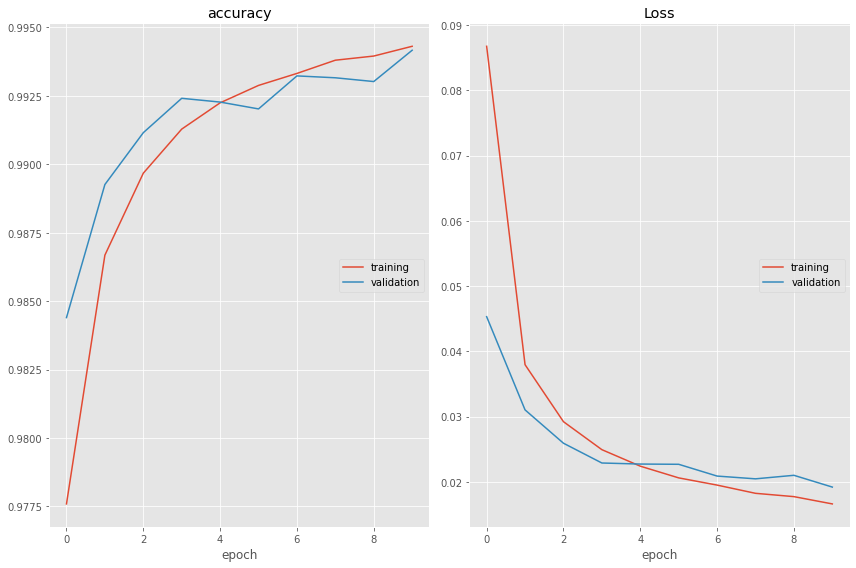

accuracy
	training         	 (min:    0.978, max:    0.994, cur:    0.994)
	validation       	 (min:    0.984, max:    0.994, cur:    0.994)
Loss
	training         	 (min:    0.017, max:    0.087, cur:    0.017)
	validation       	 (min:    0.019, max:    0.045, cur:    0.019)


In [40]:
history = model.fit([X_tr_in,X_tr_mask],y_tr,
                    validation_data=([X_val_in,X_val_mask],y_val),
                    batch_size=batch_size, 
                    epochs=10,
                    callbacks=[callbacks], 
                    verbose=1)

In [41]:
 X_te = X_te[:107*batch_size]
y_te = y_te[:107 *batch_size]
X_te_in,X_te_mask = np.array(tokenize(X_te,tokenizer))


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2111: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [42]:
preds = model.predict([X_te_in,X_te_mask], verbose=1, batch_size=batch_size)

107/107 [==============================] - 30s 260ms/step


In [43]:
# in case of classification
# idx2tag = {i: w for w, i in tags2index.items()}

# in case of extraction of entities
idx2tag = {}
for k,v in tags2index.items():
    if v == 0:
        idx2tag[v] = 'O'
    elif v == 1:
        idx2tag[v] = "LIVING"
    else:
      idx2tag[v] = " NON-LIVING"
        
def pred2label(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            p_i = np.argmax(p)
            out_i.append(idx2tag[p_i].replace("PADword", "O"))
        out.append(out_i)
    return out

def test2label(pred):
    out = []
    for pred_i in pred:
        out_i = []
        for p in pred_i:
            out_i.append(idx2tag[p].replace("PADword", "O"))
        out.append(out_i)
    return out

In [44]:
pred_labels = pred2label(preds)

In [45]:
np.array(pred_labels).shape

(3424, 50)

In [46]:
preds.shape

(3424, 50, 3)

In [47]:
y_te.shape

(3424, 50)

In [48]:
test_labels = test2label(y_te)

In [49]:
np.array(test_labels).shape

(3424, 50)

In [50]:
print(classification_report(pred_labels, test_labels))

/usr/local/lib/python3.7/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning:  NON-LIVING seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: LIVING seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))


              precision    recall  f1-score   support

       IVING       0.82      0.89      0.86      3261
      LIVING       0.61      0.80      0.69       401

   micro avg       0.79      0.88      0.84      3662
   macro avg       0.72      0.85      0.77      3662
weighted avg       0.80      0.88      0.84      3662



In [51]:
print(f1_score(pred_labels, test_labels,average='micro'))

/usr/local/lib/python3.7/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning:  NON-LIVING seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.7/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: LIVING seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))


0.8363730435907386
